In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import math

In [2]:
import matplotlib.colors as mcolors

c1 = 'tab:blue'   #S
c2 = 'tab:orange' #E
c3 = 'tab:green'  #I
c4 = 'tab:red'    #R
c5 = 'tab:purple' #D
c6 = 'tab:brown'  #Hospital
c7 = 'tab:pink'   #Outside
c8 = 'tab:gray'   #Positive
c9 = 'tab:olive'  #Rh
c10= 'tab:cyan'   #Ro

# Parameters set

In [3]:
# parameters

t_max = 180             # simulation duration
dt    = 0.01
pop   = 1000000         # total population
b     = 1
m     = 0.04
g     = 0.2 - m         # E -> I 1/incubtation
dh    = 0.007
rh    = 0.093
do    = 0.010
ro    = 0.090

# initial state

Sh = 1
Eh = 1
Ih = 1
Rh = 0
Dh = 0

So = 999900
Eo = 0
Io = 97
Ro = 0
Do = 0

ini_state = [Sh, Eh, Ih, Rh, Dh, So, Eo, Io, Ro, Do
    ]

# Defining functions

In [4]:
def sigmoid(a):
    e = math.e
    s = 1 / (1 + e**-a)
    return s

In [5]:
def tSEIRD(v, t, a, m, b, g, rh, dh, ro, do, n, p, Se, Sp, cap):
    beds = np.sum(ini_state) * cap
    return [
        - b * v[0] * v[2]/ (v[0] + v[1] + v[2]) + m * v[1] - a * v[0], #[0] S_h
        b * v[0] * v[2] / (v[0] + v[1] + v[2]) - (m + g) * v[1] + n * (1 - Sp) * v[6] * sigmoid(beds-(v[0]+v[1]+v[2])), #[1] E_h
        g * v[1] - (rh + dh) * v[2] + p * Se * v[7] * sigmoid(beds-(v[0]+v[1]+v[2])), #[2] I_h
        rh * v[2], #[3] R_h
        dh * v[2], #[4] D_h
        - b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) + m * v[6] + a * v[0], #[5] S_o
        b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) - (m + g) * v[6] - n * (1 - Sp) * v[6] * sigmoid(beds - (v[0]+v[1]+v[2])) ,#[6] E_o
        g * v[6] - (ro + do) * v[7] - p * Se * v[7] * sigmoid(beds - (v[0]+v[1]+v[2])), #[7] I_o
        ro * v[7], #[8] R_o
        do * v[7] #[9] D_o
                ]

In [6]:
def tSEIRD_matrix(Se,Sp,n,p,cap=0.1,a=0):

    times = np.arange(0, t_max, dt)
    args = (a, m, b, g, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Sh'] = df[0]# / 1000
    df['Eh'] = df[1]# / 1000
    df['Ih'] = df[2]# / 1000
    df['Rh'] = df[3]# / 1000
    df['Dh'] = df[4]# / 1000
    
    df['So'] = df[5]# / 1000
    df['Eo'] = df[6]# / 1000
    df['Io'] = df[7]# / 1000
    df['Ro'] = df[8]# / 1000
    df['Do'] = df[9]# / 1000
    
    df['Susceptible'] = (df[0] + df[5])# / 1000 #10
    df['Exposed']     = (df[1] + df[6])# / 1000 #11
    df['Infectious']  = (df[2] + df[7])# / 1000 #12
    df['Recovered']   = (df[3] + df[8])# / 1000 #13
    df['Dead']        = (df[4] + df[9])# / 1000 #14

    df['Hospitalised']= (df[0] + df[1] + df[2])# / 1000 #15
    df['Outside']     = (df[3] + df[5] + df[6] + df[7] + df[8])# / 1000 #16
    
    df['TP']          = (p * Se * df[7])# / 1000 #17
    df['FP']          = (n * (1 - Sp) * df[6])# / 1000 #18
    df['Positive']    = df['TP'] + df['FP'] #19

    df['all']         = (df[0]+df[1]+df[2]+df[3]+df[4]+df[5]+df[6]+df[7]+df[8]+df[9])# / 1000 #20
    df['beta_in']     = b / df['Hospitalised'] #21
    df['beta_out']    = b / df['Outside'] #22
    
    df['R(t)|in']  =  (b * g * df[0]) / ((rh + dh) * (df[0]+df[1]+df[2]) * (g + m))
    df['R(t)|out'] =  (b * g * df[5]) / ((ro + do) * (df[3]+df[5]+df[6]+df[7]+df[8]) * (g + m))
    
    df['deltaDh']  = dh * df[2]
    df['deltaDo'] = do * df[7]
    
    df['deltaDead'] = df['deltaDh'] + df['deltaDo']
    
    df['b_all'] = (df['beta_in'] * df['Sh'] + df['beta_out'] * df['So']) / (df['Sh'] + df['So'])

    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return df_

In [7]:
def tSEIRD_max(Se,Sp,n,p,cap=0.1,a=0):
    
    times = np.arange(0, t_max, dt)
    args = (a, m, b, g, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Positive'] = (p * Se * df[7]) + (n * (1 - Sp) * df[6])
    df['TP']       = (p * Se * df[7])
    df['FP']       = (n * (1 - Sp) * df[6])

    df['Hospitalised']= df[0] + df[1] + df[2]
    df['Sh'] = df[0]
    df['Eh'] = df[1]
    df['Ih'] = df[2]

    df['Dead']= (df[4] + df[9])
    df['Dh'] = df[4]
    df['Do'] = df[9]
    
    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return [np.max(df_['Positive']),np.max(df_['Hospitalised']),np.max(df_['Dead'])]

# Capcity set to 0.1

<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)
<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)
<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)
<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)
<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)


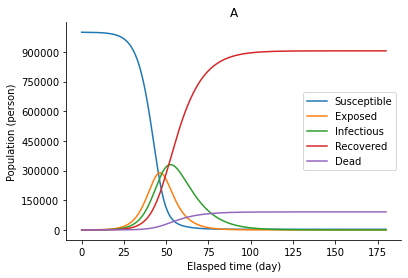

In [8]:
fig, ax = plt.subplots()
ax.set_title('A')  

t = np.arange(0, t_max, dt)

y1 = tSEIRD_matrix(0.7,0.7,0.5,0.01)[['Susceptible']]
l1 = 'Susceptible'
ax.plot(t, y1, color=c1, label=l1)

y2 = tSEIRD_matrix(0.7,0.7,0.5,0.01)[['Exposed']]
l2 = 'Exposed'
ax.plot(t, y2, color=c2, label=l2)

y3 = tSEIRD_matrix(0.7,0.7,0.5,0.01)[['Infectious']]
l3 = 'Infectious'
ax.plot(t, y3, color=c3, label=l3)

y4 = tSEIRD_matrix(0.7,0.7,0.5,0.01)[['Recovered']]
l4 = 'Recovered'
ax.plot(t, y4, color=c4, label=l4)

y5 = tSEIRD_matrix(0.7,0.7,0.5,0.01)[['Dead']]
l5 = 'Dead'
ax.plot(t, y5, color=c5, label=l5)

ax.set_xlabel('Elasped time (day)')
ax.set_ylabel('Population (person)')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().get_yaxis().set_major_locator(ticker.MaxNLocator(integer=True))

ax.legend(loc=0)

plt.show()

<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)
<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)
<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)


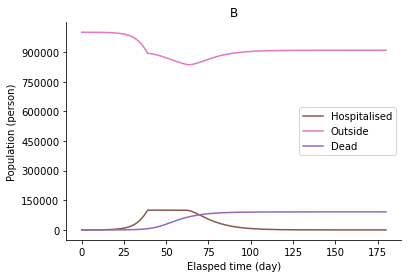

In [9]:
fig, ax = plt.subplots()
ax.set_title('B')

t = np.arange(0, t_max, dt)

y1 = tSEIRD_matrix(0.7,0.7,0.5,0.01)[['Hospitalised']]
l1 = 'Hospitalised'
ax.plot(t, y1, color=c6, label=l1)

y2 = tSEIRD_matrix(0.7,0.7,0.5,0.01)[['Outside']]
c2 = 'orange'
l2 = 'Outside'
ax.plot(t, y2, color=c7, label=l2)

y3 = tSEIRD_matrix(0.7,0.7,0.5,0.01)[['Dead']]
c3 = 'green'
l3 = 'Dead'
ax.plot(t, y3, color=c5, label=l3)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().get_yaxis().set_major_locator(ticker.MaxNLocator(integer=True))

ax.set_xlabel('Elasped time (day)')
ax.set_ylabel('Population (person)')

ax.legend(loc=0)

plt.show()

<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)
<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)
<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)
<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)
<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)


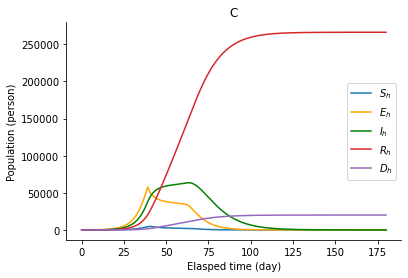

In [10]:
fig, ax = plt.subplots()
ax.set_title('C')  

t = np.arange(0, t_max, dt)

y1 = tSEIRD_matrix(0.7,0.7,0.5,0.01)[['Sh']]
l1 = '$S_h$'
ax.plot(t, y1, color=c1, label=l1)

y2 = tSEIRD_matrix(0.7,0.7,0.5,0.01)[['Eh']]
l2 = '$E_h$'
ax.plot(t, y2, color=c2, label=l2)

y3 = tSEIRD_matrix(0.7,0.7,0.5,0.01)[['Ih']]
l3 = '$I_h$'
ax.plot(t, y3, color=c3, label=l3)

y4 = tSEIRD_matrix(0.7,0.7,0.5,0.01)[['Rh']]
l4 = '$R_h$'
ax.plot(t, y4, color=c4, label=l4)

y5 = tSEIRD_matrix(0.7,0.7,0.5,0.01)[['Dh']]
l5 = '$D_h$'
ax.plot(t, y5, color=c5, label=l5)

ax.set_xlabel('Elasped time (day)')
ax.set_ylabel('Population (person)')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

ax.legend(loc=5)

plt.show()

<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)
<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)
<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)
<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)
<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)


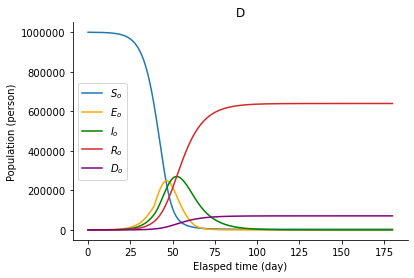

In [11]:
fig, ax = plt.subplots()
ax.set_title('D')

t = np.arange(0, t_max, dt)

y1 = tSEIRD_matrix(0.7,0.7,0.5,0.01)[['So']]
l1 = '$S_o$'
ax.plot(t, y1, color=c1, label=l1)

y2 = tSEIRD_matrix(0.7,0.7,0.5,0.01)[['Eo']]
l2 = '$E_o$'
ax.plot(t, y2, color=c2, label=l2)

y3 = tSEIRD_matrix(0.7,0.7,0.5,0.01)[['Io']]
l3 = '$I_o$'
ax.plot(t, y3, color=c3, label=l3)

y4 = tSEIRD_matrix(0.7,0.7,0.5,0.01)[['Ro']]
l4 = '$R_o$'
ax.plot(t, y4, color=c4, label=l4)

y5 = tSEIRD_matrix(0.7,0.7,0.5,0.01)[['Do']]
c5 = 'purple'
l5 = '$D_o$'
ax.plot(t, y5, color=c5, label=l5)

ax.legend(loc=6)

ax.set_xlabel('Elasped time (day)')
ax.set_ylabel('Population (person)')

plt.gca().ticklabel_format(style='plain', axis='y')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.show()

<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)
<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)
<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)


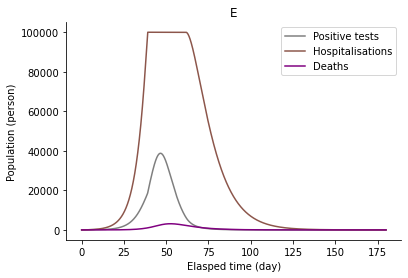

In [12]:
fig, ax = plt.subplots()
ax.set_title('E')  

t = np.arange(0, t_max, dt)

y1 = tSEIRD_matrix(0.7,0.7,0.5,0.01)[['Positive']]
l1 = 'Positive tests'
ax.plot(t, y1, color=c8, label=l1)

y2 = tSEIRD_matrix(0.7,0.7,0.5,0.01)[['Hospitalised']]
l2 = 'Hospitalisations'
ax.plot(t, y2, color=c6, label=l2)

y3 = tSEIRD_matrix(0.7,0.7,0.5,0.01)[['deltaDead']]
l3 = 'Deaths'
ax.plot(t, y3, color=c5, label=l3)

ax.set_xlabel('Elasped time (day)')
ax.set_ylabel('Population (person)')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

ax.legend(loc=0)

plt.show()

<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)
<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)


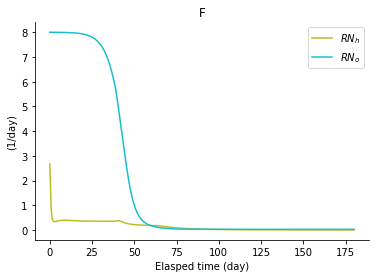

In [13]:
fig, ax = plt.subplots()
ax.set_title('F')  

t = np.arange(0, t_max, dt)

y1 = tSEIRD_matrix(0.7,0.7,0.5,0.01)[['R(t)|in']]
l1 = '$RN_h$'
ax.plot(t, y1, color=c9, label=l1)

y2 = tSEIRD_matrix(0.7,0.7,0.5,0.01)[['R(t)|out']]
l2 = '$RN_o$'
ax.plot(t, y2, color=c10, label=l2)

ax.set_xlabel('Elasped time (day)')
ax.set_ylabel('(1/day)')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

ax.legend(loc=0)

plt.show()